# Initial Setup

In [ ]:
!apt install tree
!pip install scikeras
!pip install keras-tuner

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  tree
0 upgraded, 1 newly installed, 0 to remove and 45 not upgraded.
Need to get 47.9 kB of archives.
After this operation, 116 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tree amd64 2.0.2-1 [47.9 kB]
Fetched 47.9 kB in 1s (36.8 kB/s)
Selecting previously unselected package tree.
(Reading database ... 121918 files and directories currently installed.)
Preparing to unpack .../tree_2.0.2-1_amd64.deb ...
Unpacking tree (2.0.2-1) ...
Setting up tree (2.0.2-1) ...
Processing triggers for man-db (2.10.2-1) ...
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 8.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 28.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.2/311.2 kB 3.9 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found

In [ ]:
from google.colab import drive

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!tree -d "/content/drive/My Drive/Thesis/partitioned_dataset"

/content/drive/My Drive/Thesis/partitioned_dataset
├── test_30
│   ├── Emergency_Vehicle
│   ├── Explosion
│   ├── Gunshot
│   ├── Other_(Music,Bell,Speech,Silence,Sneeze)
│   └── Power_Tool
└── train_70
    ├── Emergency_Vehicle
    ├── Explosion
    ├── Gunshot
    ├── Other_(Music,Bell,Speech,Silence,Sneeze)
    └── Power_Tool

12 directories


# Imports

In [ ]:
import tensorflow as tf
from tensorflow import keras
import tensorflow_datasets as tfds
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from keras.preprocessing import image
import numpy as np

# Data Processing

In [ ]:
train_dir = "/content/drive/My Drive/Thesis/partitioned_dataset/train_70"
test_dir = "/content/drive/My Drive/Thesis/partitioned_dataset/test_30"

In [ ]:
# to make all features equally important
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

In [ ]:
batch = 100
# steps_per_epoch = len(X_train)//batch_size

# validation_steps = len(X_test)//batch_size # if you have validation data

In [ ]:
# train_generator = train_datagen.flow_from_directory(
#         train_dir, # el directorio donde están las imágenes de train
#         target_size= (150, 150), # se hace un reescalado (no tienen el mismo tamaño)
#         batch_size= batch, # Cuántas imágenes se toman en iteración
#         class_mode='categorical') # Clasificacón binaria, cada carpeta dentro de train_dir
#                              # es una clase.

# test_generator = test_datagen.flow_from_directory(
#         test_dir,
#         target_size= (150, 150),
#         batch_size= batch,
#         class_mode='categorical')


Found 3482 images belonging to 5 classes.
Found 1492 images belonging to 5 classes.


# Transfer Learning Model Definition

In [ ]:
# Pre-trained model
base_model = tf.keras.applications.VGG16(weights='imagenet', include_top=False, input_shape=(150,150,3))
base_model.summary()

58889256/58889256 [==============================] - 4s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                              

In [ ]:
base_model.trainable = False
model = keras.Sequential([
    base_model,
    keras.layers.AveragePooling2D(pool_size=(7, 7), strides=(7,7), padding="same"), # Procesar todas las imágenes como vectores hasta este punto, una matriz numérica donde cada fila es una imagen, se guarda en una estructura como matriz de numpy (ejemplo).
])

In [ ]:
def feature_extraction(img_path, model):
    img = image.load_img(img_path, target_size=(150, 150))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)

    features = model.predict(img_array)
    return features

In [ ]:
import os

def get_png_paths(root_dir):
    png_paths = []
    for dirpath, _, filenames in os.walk(root_dir):
        for filename in filenames:
            if filename.lower().endswith('.png'):
                png_paths.append(os.path.abspath(os.path.join(dirpath, filename)))
    return png_paths

root_directory = "/content/drive/My Drive/Thesis/partitioned_dataset"
png_paths = get_png_paths(root_directory)

print(len(png_paths))
print(png_paths[0].split('/')[-2])

4974
Emergency_Vehicle


In [ ]:
features = []
indexToLabel = dict()
i = 0
for img_path in png_paths:
    features.append(feature_extraction(img_path, model).flatten())
    indexToLabel[i] = img_path.split('/')[-2]
    i += 1

print(len(features))
print(len(features[0]))

1/1 [==============================] - 0s 18ms/step
4974
512


In [ ]:
import csv
save_path = "/content/drive/My Drive/Thesis/"

# Save the array using numpy.save()
np.save(save_path + '/resulting_array.npy', features)

with open(save_path + '/indexToLabel.csv', 'w', newline='') as csv_file:
    csv_writer = csv.writer(csv_file)
    csv_writer.writerow(['Key', 'Value'])  # Write header

    for key, value in indexToLabel.items():
        csv_writer.writerow([key, value])


In [ ]:
print(len(features))
print(len(features[0]))
print(features[0])

4974
512
[2.1306231e+00 0.0000000e+00 3.5060653e-01 0.0000000e+00 1.9816010e+00
 3.4840509e-01 0.0000000e+00 0.0000000e+00 3.4477466e-01 0.0000000e+00
 0.0000000e+00 0.0000000e+00 4.4104795e+00 0.0000000e+00 1.3727015e-02
 4.6367481e-02 0.0000000e+00 9.5721693e+00 1.9062345e+00 8.5204795e-02
 0.0000000e+00 0.0000000e+00 0.0000000e+00 7.2808629e-01 0.0000000e+00
 0.0000000e+00 0.0000000e+00 5.3174591e+00 1.0257016e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 2.2936447e+00 0.0000000e+00 0.0000000e+00
 8.8848934e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 2.1770871e+00 1.9819446e+00 0.0000000e+00 1.9904251e+01
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 8.0230112e+00
 6.3686705e+00 0.0000000e+00 0.0000000e+00 6.2618017e+00 5.0980778e+00
 6.9478834e-01 4.4559669e-01 4.5669479e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 1.2409519e-01 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+

# *Load* the Data

In [ ]:
import numpy as np
import pandas as pd

# Load features
features = np.load("/content/drive/My Drive/Thesis/resulting_array.npy")

# Load labels
label_df = pd.read_csv("/content/drive/My Drive/Thesis/indexToLabel.csv")
labels = label_df["Value"].to_numpy()
# Convert string labels to integers
label_mapping = {label: index for index, label in enumerate(np.unique(labels))}
print(np.unique(labels))
labels = np.array([label_mapping[label] for label in labels])

# One-hot encode the integer labels
num_classes = len(np.unique(labels))
labels = tf.keras.utils.to_categorical(labels, num_classes)

print(labels)
print(labels.shape)
print(features.shape)
print(num_classes)

['Emergency_Vehicle' 'Explosion' 'Gunshot'
 'Other_(Music,Bell,Speech,Silence,Sneeze)' 'Power_Tool']
[[1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 ...
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0.]]
(4974, 5)
(4974, 512)
5


Split the data into training and validation sets

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(features, labels, test_size=0.2, random_state=42)


model architecture

In [ ]:
# Build your model on top of the extracted features

model = tf.keras.Sequential([
    # Replace with your desired layers here
    keras.layers.Dense(512, activation="relu", kernel_regularizer=keras.regularizers.L2(0.5)),
    keras.layers.Dropout(0.1),
    keras.layers.Dense(num_classes, activation="softmax")
])
opt = keras.optimizers.Adam(learning_rate=0.0001)
# Compile the model with an optimizer and loss function
model.compile(optimizer=opt, loss="categorical_crossentropy", metrics=[keras.metrics.CategoricalAccuracy()])


Train the model

In [ ]:
history = model.fit(X_train, y_train, epochs=50, validation_data=(X_val, y_val))


Epoch 1/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 11s 50ms/step - categorical_accuracy: 0.3058 - loss: 235.3787 - val_categorical_accuracy: 0.5568 - val_loss: 166.4454
Epoch 2/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - categorical_accuracy: 0.5341 - loss: 149.6701 - val_categorical_accuracy: 0.6281 - val_loss: 105.1296
Epoch 3/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - categorical_accuracy: 0.6021 - loss: 94.1645 - val_categorical_accuracy: 0.6523 - val_loss: 65.4665
Epoch 4/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - categorical_accuracy: 0.6038 - loss: 58.5269 - val_categorical_accuracy: 0.6623 - val_loss: 40.3859
Epoch 5/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - categorical_accuracy: 0.6195 - loss: 36.0773 - val_categorical_accuracy: 0.6975 - val_loss: 24.8477
Epoch 6/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - categorical_accuracy: 0.6612 - loss: 22.2296 - val_categorical_accuracy: 0.7095 - val_loss: 15.4556
Epoch 7/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - categorical_accu

Evaluate the model

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - categorical_accuracy: 0.6896 - loss: 0.9342 
Validation categorical accuracy: 0.7015075087547302


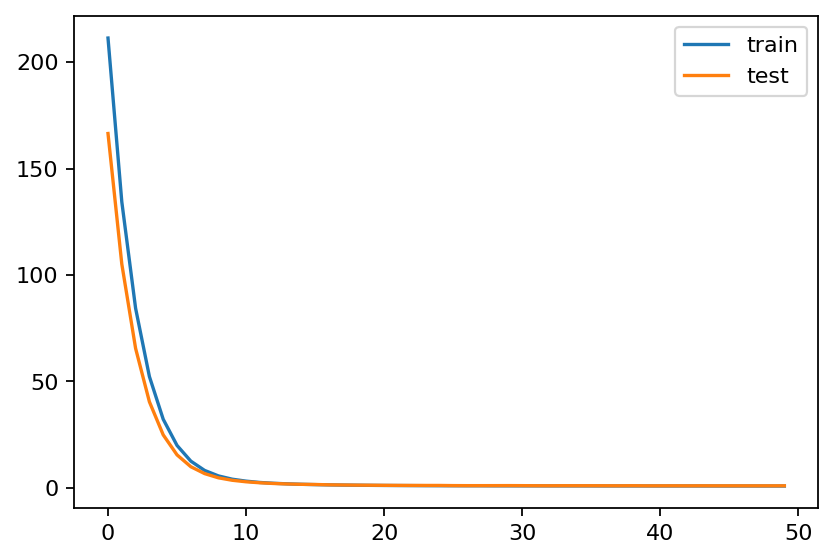

In [ ]:
loss, accuracy = model.evaluate(X_val, y_val)
print("Validation categorical accuracy:", accuracy)
plt.figure(figsize=(6, 4), dpi=160)

plt.plot(history.history["loss"], label="train")
plt.plot(history.history["val_loss"], label="test")
plt.legend()
plt.show()


In [ ]:
# https://www.youtube.com/watch?v=6Nf1x7qThR8
import tensorflow as tf
from sklearn.model_selection import GridSearchCV, train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.regularizers import L2
from sklearn.metrics import make_scorer, accuracy_score
import numpy as np
import keras_tuner as kt

# Function to create model
import keras_tuner as kt
from tensorflow import keras

# Function to create model
def model_builder(params):
    model = Sequential()

    param_learning_rate = params.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4, 1e-5])
    param_l2_reg = params.Choice('kernel_regularizer', values=[0.5, 0.05, 0.005, 0.0005])
    param_dropout = params.Choice('dropout_rate', values=[0.6, 0.5, 0.4, 0.3, 0.2, 0.1, 0.005])
    param_batch_size = params.Choice('batch_size', values=[16, 32, 64, 128])

    model.add(Dense(512, activation="relu", kernel_regularizer=L2(param_l2_reg)))
    model.add(Dropout(param_dropout))
    model.add(Dense(num_classes, activation="softmax"))

    opt = keras.optimizers.Adam(learning_rate=param_learning_rate)

    model.compile(optimizer=opt, loss="categorical_crossentropy", metrics=[keras.metrics.CategoricalAccuracy()])

    return model

# Creating the tuner
tuner = kt.RandomSearch(
    model_builder,
    objective=kt.Objective('val_categorical_accuracy', direction='max'),  # Tune for val accuracy
    max_trials=20,
    executions_per_trial=2,  # Run each trial multiple times to account for randomness
    directory='dir',
    project_name='random_search_tuning'
)

# Performing the hyperparameter search
tuner.search(X_train, y_train, epochs=100, validation_split=0.2)

Trial 20 Complete [00h 01m 23s]
val_categorical_accuracy: 0.7305276393890381

Best val_categorical_accuracy So Far: 0.7487437129020691
Total elapsed time: 00h 26m 20s


In [ ]:
best_params = tuner.get_best_hyperparameters(num_trials=1)[0]
tuner.get_best_hyperparameters()[0].values

{'learning_rate': 0.001,
 'kernel_regularizer': 0.005,
 'dropout_rate': 0.6,
 'batch_size': 64}

Epoch 1/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - categorical_accuracy: 0.4600 - loss: 6.3547 - val_categorical_accuracy: 0.6784 - val_loss: 2.4525
Epoch 2/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - categorical_accuracy: 0.6364 - loss: 2.4998 - val_categorical_accuracy: 0.6975 - val_loss: 2.0121
Epoch 3/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - categorical_accuracy: 0.6957 - loss: 1.9502 - val_categorical_accuracy: 0.7035 - val_loss: 1.7516
Epoch 4/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - categorical_accuracy: 0.7064 - loss: 1.6805 - val_categorical_accuracy: 0.6935 - val_loss: 1.5677
Epoch 5/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - categorical_accuracy: 0.7213 - loss: 1.5032 - val_categorical_accuracy: 0.7136 - val_loss: 1.4531
Epoch 6/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - categorical_accuracy: 0.7215 - loss: 1.3886 - val_categorical_accuracy: 0.6965 - val_loss: 1.3746
Epoch 7/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - categorical_accuracy: 0.7290 - lo

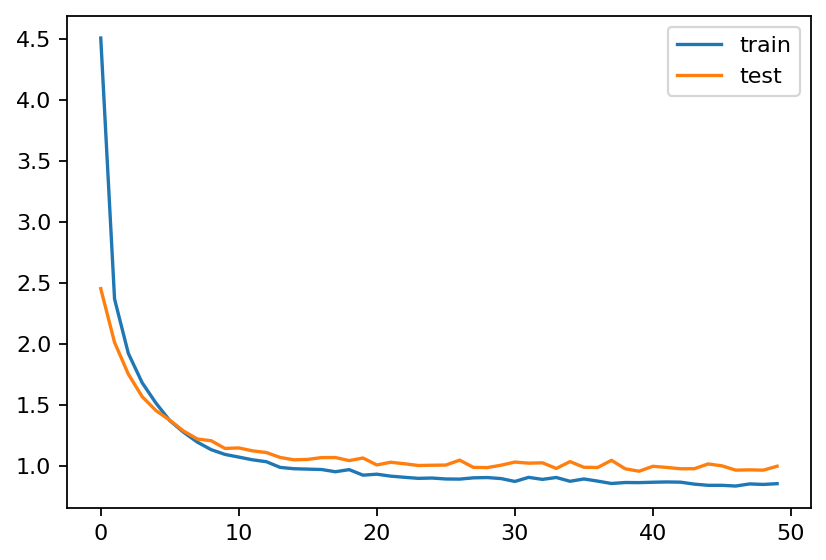

In [ ]:
model = tuner.hypermodel.build(best_params)
history = model.fit(X_train, y_train, epochs=50, validation_data=(X_val, y_val))
loss, accuracy = model.evaluate(X_val, y_val) # utilizar un x_test, y_test que no fue utilizado para entrenamiento
print("Validation accuracy:", accuracy)
plt.figure(figsize=(6, 4), dpi=160)

plt.plot(history.history["loss"], label="train")
plt.plot(history.history["val_loss"], label="test")
plt.legend()
plt.show()

Delete HyperParam Tuning Dir

In [ ]:
import shutil
import os

# Define the path to the directory
directory_path = 'dir/random_search_tuning'

# Check if the directory exists
if os.path.exists(directory_path):
    # Remove the directory and all its contents
    shutil.rmtree(directory_path)
    print(f"Directory {directory_path} has been removed.")
else:
    print(f"Directory {directory_path} does not exist.")


Directory dir/random_search_tuning has been removed.
